In [364]:
# by Grossmend, 2018

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

## <b><font color='3C89F9'>1. Data preparation</font></b>

In [151]:
# load data

# train data
train_data = pd.read_csv('C:/Users/market8/Desktop/GitHub/CSV/titanic/dataset_kaggle/train.csv')

# test data
test_data = pd.read_csv('C:/Users/market8/Desktop/GitHub/CSV/titanic/dataset_kaggle/test.csv')

In [152]:
# check duplecated field "PassengerId"
print(any(train_data['PassengerId'].duplicated()))
print(any(test_data['PassengerId'].duplicated()))

False
False


In [153]:
# concat train and test data in one DataFrame
all_data = pd.concat([train_data.set_index('PassengerId'), test_data.set_index('PassengerId')], keys=['train', 'test'], axis=0, sort=False)

# show first 10 row data
all_data.head(10)

Survived  Pclass  \
      PassengerId                     
train 1                 0.0       3   
      2                 1.0       1   
      3                 1.0       3   
      4                 1.0       1   
      5                 0.0       3   
      6                 0.0       3   
      7                 0.0       1   
      8                 0.0       3   
      9                 1.0       3   
      10                1.0       2   

                                                                Name     Sex  \
      PassengerId                                                              
train 1                                      Braund, Mr. Owen Harris    male   
      2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
      3                                       Heikkinen, Miss. Laina  female   
      4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
      5                                     Allen, Mr. William Henry    male   
      6                                             Moran, Mr. James    male   
      7                                      McCarthy, Mr. Timothy J    male   
      8                               Palsson, Master. Gosta Leonard    male   
      9            Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female   
      10                         Nasser, Mrs. Nicholas (Adele Achem)  female   

                    Age  SibSp  Parch            Ticket     Fare Cabin  \
      PassengerId                                                        
train 1            22.0      1      0         A/5 21171   7.2500   NaN   
      2            38.0      1      0          PC 17599  71.2833   C85   
      3            26.0      0      0  STON/O2. 3101282   7.9250   NaN   
      4            35.0      1      0            113803  53.1000  C123   
      5            35.0      0      0            373450   8.0500   NaN   
      6             NaN      0      0            330877   8.4583   NaN   
      7            54.0      0      0             17463  51.8625   E46   
      8             2.0      3      1            349909  21.0750   NaN   
      9            27.0      0      2            347742  11.1333   NaN   
      10           14.0      1      0            237736  30.0708   NaN   

                  Embarked  
      PassengerId           
train 1                  S  
      2                  C  
      3                  S  
      4                  S  
      5                  S  
      6                  Q  
      7                  S  
      8                  S  
      9                  S  
      10                 C

In [154]:
# description of columns:

# Survived - Survival (0 = No; 1 = Yes)
# Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
# Name - Name
# Sex - Sex
# Age - Age
# SibSp - Number of Siblings/Spouses Aboard
# Parch - Number of Parents/Children Aboard
# Ticket - Ticket Number
# Fare - Passenger Fare ()
# Cabin - Cabin (Number)
# Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [155]:
# show info
all_data.info()
print(pd.__version__)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (train, 1) to (test, 1309)
Data columns (total 11 columns):
Survived    891 non-null float64
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 126.6+ KB
0.24.1


In [156]:
# count empty values
print('Empty values:')
all_data.isnull().sum()

Empty values:


Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [157]:
all_data['Counter'] = 1

### <b><font color='green'>"Name"</font> field processing</b>

In [158]:
# select 'Title' from field 'Name'

def title_parser(name):
    
    if not isinstance(name, str):
        return name
        
    if len(name.split()) == 1:
        return name
    
    try:
        parser_name = name.split(',')[1].split('.')[0].strip()
    except Exception as e:
        parser_name = 'error_parse'
    
    if parser_name == 'Mlle' or parser_name == 'Miss':
        parser_name = 'Miss'
    elif parser_name == 'Mme' or parser_name == 'Lady' or parser_name == 'Ms' or parser_name == 'Mrs':
        parser_name = 'Mrs'
    elif parser_name == 'Master':
        parser_name = 'Master'
    elif parser_name == 'Mr':
        parser_name = 'Mr'
    elif parser_name == 'error_parse':
        parser_name = 'error_parse'
    else:
        parser_name = 'Other'
        
    return parser_name


# processing field 'Name'
all_data['Name'] = all_data['Name'].apply(title_parser)

# unique count field 'Name' after processing
all_data['Name'].value_counts()

Mr        757
Miss      262
Mrs       201
Master     61
Other      28
Name: Name, dtype: int64

In [159]:
# normalize between 0 and 1 field 'Name'

def name_to_number(name):
    
    if not isinstance(name, str):
        return name
    
    if name == 'Mr':
        number_name = 0
    elif name == 'Miss':
        number_name = 1
    elif name == 'Mrs':
        number_name = 2
    elif name == 'Master':
        number_name = 3
    elif name == 'Other':
        number_name = 4
    else:
        number_name = -1
        
    return float(number_name)

# convert field 'Name' string to number
all_data['Name'] = all_data['Name'].apply(name_to_number)

# # alternative methods
# all_data['Name'] = all_data['Name'].replace(['Mr', 'Miss', 'Mrs', 'Master', 'Other'], [0, 1, 2, 3, 4])
# all_data['Name'] = all_data['Name'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Other': 4})

# normalize between 0 and 1 field 'Name'
scaler = MinMaxScaler()
all_data['Name'] = scaler.fit_transform(all_data[['Name']])
all_data['Name'].value_counts()

0.00    757
0.25    262
0.50    201
0.75     61
1.00     28
Name: Name, dtype: int64

### <b><font color='green'>"Sex"</font> field processing</b>

In [160]:
# look at survival by sex
print(all_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [161]:
# look at count survival by 'sex' and 'class'

all_data.groupby(["Pclass", "Sex"])["Survived"].value_counts()

Pclass  Sex     Survived
1       female  1.0          91
                0.0           3
        male    0.0          77
                1.0          45
2       female  1.0          70
                0.0           6
        male    0.0          91
                1.0          17
3       female  0.0          72
                1.0          72
        male    0.0         300
                1.0          47
Name: Survived, dtype: int64

In [162]:
# normalize between 0 and 1 field 'Sex'

def sex_to_number(name):
    
    if not isinstance(name, str):
        return name
    
    if name == 'male':
        number_sex = 0
    elif name == 'female':
        number_sex = 1
    else:
        number_sex = -1
        
    return float(number_sex)

# convert field 'Name' string to number
all_data['Sex'] = all_data['Sex'].apply(sex_to_number)

# normalize between 0 and 1 field 'Name'
scaler = MinMaxScaler()
all_data['Sex'] = scaler.fit_transform(all_data[['Sex']])
all_data['Sex'].value_counts()

0.0    843
1.0    466
Name: Sex, dtype: int64

### <b><font color='green'>"Family"</font> create field and processing</b>

In [163]:
print(np.dtype(all_data['SibSp']))
print(np.dtype(all_data['Parch']))

# create new field 'Family' from sum 'SibSp' + 'Parch'
all_data['Family'] = all_data['SibSp'].astype(int) + all_data['Parch'] + 1

# convert column to float
all_data['Family'] = all_data["Family"]

# view how influence 'Family' survival
df_family = all_data[['Family', 'Survived', 'Counter']].copy()
df_family.groupby('Family', as_index=False).agg({'Survived': 'mean', 'Counter': 'count'}).rename(columns={'Counter': 'Count'})

int64
int64


,Family,Survived,Count
0,1,0.303538,790
1,2,0.552795,235
2,3,0.578431,159
3,4,0.724138,43
4,5,0.200000,22
5,6,0.136364,25
6,7,0.333333,16
7,8,0.000000,8
8,11,0.000000,11


In [164]:
def family_agr(family_count):
    
    """ function group family count """
    
    if not isinstance(family_count, int):
        return family_count
    
    if family_count == 1:
        family_group = 1
    elif (family_count == 2) or (family_count == 3):
        family_group = 2
    elif family_count == 4:
        family_group = 3
    elif (family_count == 5) or (family_count == 6) or (family_count == 7):
        family_group = 4
    elif (family_count == 8) or (family_count == 11):
        family_group = 5
    else:
        family_group = 6
    
    return float(family_group)
    
    
# convert field 'Name' string to number
all_data['Family'] = all_data['Family'].apply(family_agr)
all_data.groupby('Family', as_index=False).agg({'Survived': 'mean', 'Counter': 'count'}).rename(columns={'Counter': 'Count'})

,Family,Survived,Count
0,1.0,0.303538,790
1,2.0,0.562738,394
2,3.0,0.724138,43
3,4.0,0.204082,63
4,5.0,0.000000,19


In [165]:
# normalize field 'Family'
scaler = MinMaxScaler()
all_data['Family'] = scaler.fit_transform(all_data[['Family']])
all_data['Family'].value_counts()

0.00    790
0.25    394
0.75     63
0.50     43
1.00     19
Name: Family, dtype: int64

### <b><font color='green'>"Fare"</font> field processing</b>

In [166]:
# count empty value field "Fare"
print('Count empty "Fare":', all_data['Fare'].isnull().sum())

Count empty "Fare": 1


In [167]:
# fill empty values mean group from filed "Pclass"
all_data['Fare'] = all_data['Fare'].fillna(all_data.groupby('Pclass')['Fare'].transform('mean'))
print('Count empty "Fare":', all_data['Fare'].isnull().sum())

Count empty "Fare": 0


In [168]:
# field "Fare" contains zero values
print('Zero counts in field "Fare"', all_data[all_data['Fare'] == 0].shape[0])

# fill zero values mean group from fields "Pclass" and "Sex" (slow method)
all_data['Fare'] = all_data['Fare'].replace(0, all_data.groupby('Pclass')['Fare'].transform('mean'))

print('Count zero "Fare":', all_data['Fare'][all_data['Fare']==0].count())

Zero counts in field "Fare" 17
Count zero "Fare": 0


Text(0.5, 1.0, '"Fare" field sort values')

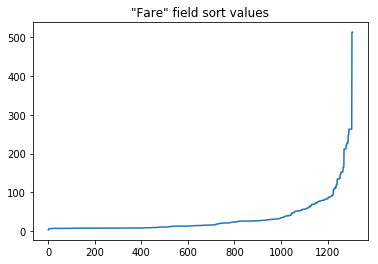

In [169]:
# view "Fare" values
plt.plot(all_data['Fare'].sort_values().reset_index(drop=True));
plt.title('"Fare" field sort values')

In [170]:
# convert fielf "Fare" to categorical
all_data['Fare'] = pd.cut(all_data['Fare'], bins=10, labels=False).astype('float')

In [171]:
# normalize field 'Fare'
scaler = MinMaxScaler()
all_data['Fare'] = scaler.fit_transform(all_data[['Fare']])
all_data['Fare'].value_counts()

0.000000    1088
0.111111     137
0.222222      42
0.444444      21
0.555556      13
0.333333       4
1.000000       4
Name: Fare, dtype: int64

### <b><font color='green'>"Age"</font> field processing</b>

In [172]:
print('Count empty "Age" field:', all_data['Age'].isnull().sum())
print('Percentage empty "Age" field:', round(all_data['Age'].isnull().sum() / all_data.shape[0] * 100, 2), '%')

Count empty "Age" field: 263
Percentage empty "Age" field: 20.09 %


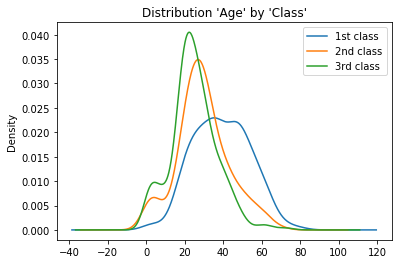

In [173]:
# plot distribution "Age" by "Class"
all_data['Age'][all_data['Pclass'] == 1].plot(kind='kde');
all_data['Age'][all_data['Pclass'] == 2].plot(kind='kde');
all_data['Age'][all_data['Pclass'] == 3].plot(kind='kde');
plt.title("Distribution 'Age' by 'Class'");
plt.legend(('1st class', '2nd class','3rd class'),loc='best');

In [174]:
# fill empty values "Age" by "Name" (processing previos)
all_data['Age'] = all_data['Age'].fillna(all_data.groupby('Name')['Age'].transform('mean'))

In [175]:
# convert fielf "Fare" to categorical
all_data['Age'] = pd.cut(all_data['Age'], bins=10, labels=False).astype('float')

In [176]:
# normalize field 'Fare'
scaler = MinMaxScaler()
all_data['Age'] = scaler.fit_transform(all_data[['Age']])
all_data['Age'].value_counts()

0.444444    365
0.222222    324
0.333333    250
0.555556    109
0.000000     80
0.666667     65
0.111111     62
0.777778     41
0.888889     10
1.000000      3
Name: Age, dtype: int64

In [177]:
# all_data['Counter'] = 1
# all_data[['Pclass', 'Fare']].groupby('Pclass', as_index=False).mean()
# all_data[['Pclass', 'Survived', 'Sex', 'Fare', 'Counter']].groupby(['Pclass', 'Survived', 'Sex'], as_index=False).agg({'Fare': np.mean, 'Counter': np.sum})

# # plt.plot(all_data['Fare'].sort_values().reset_index()['Fare'])

### <b><font color='green'>"Cabin"</font> field processing</b>

In [178]:
# fill empty values
all_data['Cabin'].fillna('Z',inplace=True)

In [179]:
# select 1st element string "Cabin"
if not np.issubdtype(all_data['Cabin'].dtype, np.number):
    all_data['Cabin'] = all_data['Cabin'].map(lambda x : x[0])

In [180]:
# look "Survived" and "Counter" by "Cabin"
cabin = all_data.groupby(['Cabin'])['Survived', 'Counter'].agg({'Survived': np.mean, 'Counter': np.sum}).sort_values(by=['Counter'], ascending=[0]).reset_index()
cabin

,Cabin,Survived,Counter
0,Z,0.299854,1014
1,C,0.593220,94
2,B,0.744681,65
3,D,0.757576,46
4,E,0.750000,41
5,A,0.466667,22
6,F,0.615385,21
7,G,0.500000,5
8,T,0.000000,1


In [181]:
# string to numeric field "Cabin"
if not np.issubdtype(all_data['Cabin'].dtype, np.number):
    all_data['Cabin'] = all_data['Cabin'].map(dict(zip(cabin['Cabin'].values, cabin.index.values))).astype(float)

In [182]:
# normalize field 'Cabin'
scaler = MinMaxScaler()
all_data['Cabin'] = scaler.fit_transform(all_data[['Cabin']])
all_data['Cabin'].value_counts()

0.000    1014
0.125      94
0.250      65
0.375      46
0.500      41
0.625      22
0.750      21
0.875       5
1.000       1
Name: Cabin, dtype: int64

### <b><font color='green'>"isAlone"</font> add field</b>

In [183]:
# add field "is alone"
all_data['isAlone'] = 0
all_data.loc[all_data['Family'] == 1, 'isAlone'] = 1

In [184]:
all_data.head(10)

Survived  Pclass  Name  Sex       Age  SibSp  Parch  \
      PassengerId                                                        
train 1                 0.0       3  0.00  0.0  0.222222      1      0   
      2                 1.0       1  0.50  1.0  0.444444      1      0   
      3                 1.0       3  0.25  1.0  0.333333      0      0   
      4                 1.0       1  0.50  1.0  0.444444      1      0   
      5                 0.0       3  0.00  0.0  0.444444      0      0   
      6                 0.0       3  0.00  0.0  0.444444      0      0   
      7                 0.0       1  0.00  0.0  0.666667      0      0   
      8                 0.0       3  0.75  0.0  0.000000      3      1   
      9                 1.0       3  0.50  1.0  0.333333      0      2   
      10                1.0       2  0.50  1.0  0.111111      1      0   

                             Ticket      Fare  Cabin Embarked  Counter  \
      PassengerId                                                        
train 1                   A/5 21171  0.000000  0.000        S        1   
      2                    PC 17599  0.111111  0.125        C        1   
      3            STON/O2. 3101282  0.000000  0.000        S        1   
      4                      113803  0.000000  0.125        S        1   
      5                      373450  0.000000  0.000        S        1   
      6                      330877  0.000000  0.000        Q        1   
      7                       17463  0.000000  0.500        S        1   
      8                      349909  0.000000  0.000        S        1   
      9                      347742  0.000000  0.000        S        1   
      10                     237736  0.000000  0.000        C        1   

                   Family  isAlone  
      PassengerId                   
train 1              0.25        0  
      2              0.25        0  
      3              0.00        0  
      4              0.25        0  
      5              0.00        0  
      6              0.00        0  
      7              0.00        0  
      8              0.75        0  
      9              0.25        0  
      10             0.25        0

### <b><font color='green'>"Embarked"</font> field processing</b>

In [185]:
# count_empty values
all_data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [186]:
# replace empty values
all_data['Embarked'].fillna('N', inplace=True)

In [187]:
embarked = all_data.groupby(['Embarked'])['Survived', 'Counter'].agg({'Survived': np.mean, 'Counter': np.sum}).sort_values(by=['Counter'], ascending=[0]).reset_index()
embarked

,Embarked,Survived,Counter
0,S,0.336957,914
1,C,0.553571,270
2,Q,0.389610,123
3,N,1.000000,2


In [188]:
# string to numeric field "Embarked"
if not np.issubdtype(all_data['Embarked'].dtype, np.number):
    all_data['Embarked'] = all_data['Embarked'].map(dict(zip(embarked['Embarked'].values, embarked.index.values))).astype(float)

In [189]:
# normalize field 'Cabin'
scaler = MinMaxScaler()
all_data['Embarked'] = scaler.fit_transform(all_data[['Embarked']])
all_data['Embarked'].value_counts()

0.000000    914
0.333333    270
0.666667    123
1.000000      2
Name: Embarked, dtype: int64

### <b><font color='green'>"Pclass"</font> field processing</b>

In [190]:
# normalize field 'Pclass'
scaler = MinMaxScaler()
all_data['Pclass'] = scaler.fit_transform(all_data[['Pclass']].astype(float))
all_data['Pclass'].value_counts()

1.0    709
0.0    323
0.5    277
Name: Pclass, dtype: int64

### <b><font color='green'>"Ticket"</font> field processing</b>

In [191]:

all_data['Ticket'] = all_data['Ticket'].apply(lambda x: len(x) if isinstance(x, str) else x)
all_data['Ticket'] = pd.cut(all_data['Fare'], bins=10, labels=False).astype('float')

scaler = MinMaxScaler()
all_data['Ticket'] = scaler.fit_transform(all_data[['Ticket']].astype(float))
all_data['Ticket'].value_counts()

all_data.groupby(['Ticket'])['Survived', 'Counter'].agg({'Survived': 'mean', 'Counter': 'sum'})


,Survived,Counter
Ticket,,
0.000000,0.327517,1088
0.111111,0.634409,137
0.222222,0.741935,42
0.333333,1.000000,4
0.444444,0.636364,21
0.555556,0.666667,13
1.000000,1.000000,4


### <b>Select fields for machine learning</b>

In [192]:
# let's look at the processing result "all_data"
all_data.head(10)

Survived  Pclass  Name  Sex       Age  SibSp  Parch  \
      PassengerId                                                        
train 1                 0.0     1.0  0.00  0.0  0.222222      1      0   
      2                 1.0     0.0  0.50  1.0  0.444444      1      0   
      3                 1.0     1.0  0.25  1.0  0.333333      0      0   
      4                 1.0     0.0  0.50  1.0  0.444444      1      0   
      5                 0.0     1.0  0.00  0.0  0.444444      0      0   
      6                 0.0     1.0  0.00  0.0  0.444444      0      0   
      7                 0.0     0.0  0.00  0.0  0.666667      0      0   
      8                 0.0     1.0  0.75  0.0  0.000000      3      1   
      9                 1.0     1.0  0.50  1.0  0.333333      0      2   
      10                1.0     0.5  0.50  1.0  0.111111      1      0   

                     Ticket      Fare  Cabin  Embarked  Counter  Family  \
      PassengerId                                                         
train 1            0.000000  0.000000  0.000  0.000000        1    0.25   
      2            0.111111  0.111111  0.125  0.333333        1    0.25   
      3            0.000000  0.000000  0.000  0.000000        1    0.00   
      4            0.000000  0.000000  0.125  0.000000        1    0.25   
      5            0.000000  0.000000  0.000  0.000000        1    0.00   
      6            0.000000  0.000000  0.000  0.666667        1    0.00   
      7            0.000000  0.000000  0.500  0.000000        1    0.00   
      8            0.000000  0.000000  0.000  0.000000        1    0.75   
      9            0.000000  0.000000  0.000  0.000000        1    0.25   
      10           0.000000  0.000000  0.000  0.333333        1    0.25   

                   isAlone  
      PassengerId           
train 1                  0  
      2                  0  
      3                  0  
      4                  0  
      5                  0  
      6                  0  
      7                  0  
      8                  0  
      9                  0  
      10                 0

In [193]:
# very nice. Select fields for ML
data_for_ml = all_data[['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Family', 'isAlone', 'Ticket']]
data_for_ml.head(10)

Survived  Pclass  Name  Sex       Age      Fare  Cabin  \
      PassengerId                                                           
train 1                 0.0     1.0  0.00  0.0  0.222222  0.000000  0.000   
      2                 1.0     0.0  0.50  1.0  0.444444  0.111111  0.125   
      3                 1.0     1.0  0.25  1.0  0.333333  0.000000  0.000   
      4                 1.0     0.0  0.50  1.0  0.444444  0.000000  0.125   
      5                 0.0     1.0  0.00  0.0  0.444444  0.000000  0.000   
      6                 0.0     1.0  0.00  0.0  0.444444  0.000000  0.000   
      7                 0.0     0.0  0.00  0.0  0.666667  0.000000  0.500   
      8                 0.0     1.0  0.75  0.0  0.000000  0.000000  0.000   
      9                 1.0     1.0  0.50  1.0  0.333333  0.000000  0.000   
      10                1.0     0.5  0.50  1.0  0.111111  0.000000  0.000   

                   Embarked  Family  isAlone    Ticket  
      PassengerId                                       
train 1            0.000000    0.25        0  0.000000  
      2            0.333333    0.25        0  0.111111  
      3            0.000000    0.00        0  0.000000  
      4            0.000000    0.25        0  0.000000  
      5            0.000000    0.00        0  0.000000  
      6            0.666667    0.00        0  0.000000  
      7            0.000000    0.00        0  0.000000  
      8            0.000000    0.75        0  0.000000  
      9            0.000000    0.25        0  0.000000  
      10           0.333333    0.25        0  0.000000

In [194]:
# split dataset train data and test data for ML

X_model = data_for_ml.loc['train'].drop('Survived', axis=1).select_dtypes(include=[np.number])
y_model = data_for_ml.loc['train']['Survived']

Y_finish = data_for_ml.loc['test'].drop('Survived', axis=1).select_dtypes(include=[np.number])

print('size train data:', X_model.shape)
print('size train labels:', y_model.shape)
print('size finish test data:', Y_finish.shape)

size train data: (891, 10)
size train labels: (891,)
size finish test data: (418, 10)


## <b><font color='3C89F9'>2. Machine Learning</font></b>

### <i><font color='black'> simple Neural Network</font></i>

In [195]:
import sklearn.datasets
from sklearn.model_selection import train_test_split

mean scores: 0.818166701294504


MLPClassifier(activation='relu', alpha=0.01, batch_size=10, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[10], learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

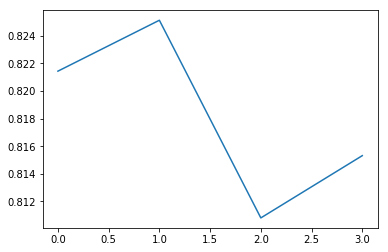

In [196]:
# cross-validation K blocks

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

model = MLPClassifier(solver='sgd',
                      random_state=0,
                      max_iter=1000,
                      batch_size=10,
                      learning_rate_init=0.001,
                      alpha=0.01,
                      hidden_layer_sizes=[10],
                      activation='relu')
scores = cross_val_score(model, X_model.values, y_model.values, cv=4)
plt.plot(scores)
print('mean scores:', np.mean(scores))
model

In [197]:
# save CSV result

model.fit(X_model, y_model)
out = model.predict(Y_finish).T.astype('int')

df_out = pd.DataFrame(data=out, index=Y_finish.index).reset_index()
df_out.columns = ['PassengerId', 'Survived']
df_out.to_csv('submission_nn.csv', index=False, sep=',')

### <i><font color='black'>XGBoost</font></i>

In [209]:
from xgboost import XGBClassifier

In [210]:
# XGBClassifier model
xgb = XGBClassifier(n_estimators=100, max_depth=3)

[0.805 0.845 0.855]


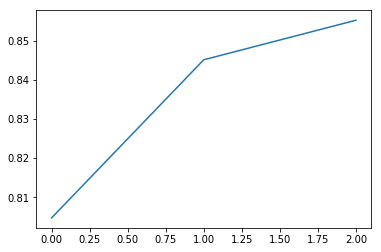

In [211]:
# cross k validation
scores = cross_val_score(xgb, X_model.values, y_model.values, cv=3)
plt.plot(scores)
print(np.round(scores, 3))

In [212]:
# save CSV result

xgb.fit(X_model, y_model)
out = xgb.predict(Y_finish).T.astype('int')

df_out = pd.DataFrame(data=out, index=Y_finish.index).reset_index()
df_out.columns = ['PassengerId', 'Survived']
df_out.to_csv('submission_xgb.csv', index=False, sep=',')

### <i><font color='black'> Deep Neural Network from Keras</font></i>

In [353]:
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers

def build_model(insh=10):
    model = models.Sequential()
    model.add(layers.Dense(insh, activation='relu'))
    model.add(layers.Dense(insh, activation='linear'))
    model.add(layers.Dense(1, activation='sigmoid'))
    opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [354]:
# split data train and test
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2)

In [355]:
# fit NN model and show accurancy
input_shape = X_train.shape[1]
DL_model = None
DL_model = build_model(insh=input_shape)

history = DL_model.fit(X_train.values,
                       y_train.values,
                       epochs=80,
                       verbose=0,
                       batch_size=32,
                       validation_data=(X_test.values, y_test.values))

In [356]:
# check scores model
DL_model.evaluate(X_test.values, y_test.values)[1]

179/179 [==============================] - 0s 90us/step


0.8100558672537351

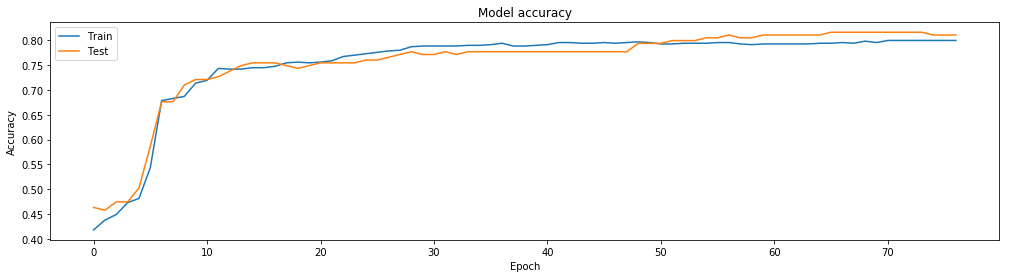

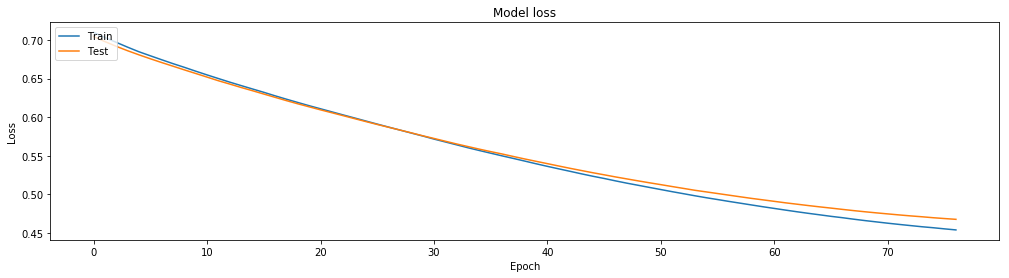

In [357]:
n = 3

# Plot training & validation accuracy values
plt.subplots(figsize=(17,4))
plt.plot(history.history['acc'][n:])
plt.plot(history.history['val_acc'][n:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.subplots(figsize=(17,4))
plt.plot(history.history['loss'][n:])
plt.plot(history.history['val_loss'][n:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [359]:
# kross k validation

kfold = StratifiedKFold(n_splits=5)

scores = []

for i in range(3):
    for train, test in kfold.split(X_model, y_model):
        nn_model = None
        nn_model = build_model(X_model.shape[1])
        nn_model.fit(X_model.iloc[train].values,
                     y_model.iloc[train].values,
                     epochs=100,
                     verbose=0)
        acc = nn_model.evaluate(X_model.iloc[test].values, y_model.iloc[test].values, verbose=0)[1]
        scores.append(acc)
        print('accuracy step ' + str(len(scores)) + ': ', acc)

In [362]:
y_model.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            882, 883, 884, 885, 886, 887, 888, 889, 890, 891],
           dtype='int64', name='PassengerId', length=891)

In [321]:
# save CSV result

nn_model = None
nn_model = build_model()

nn_model.fit(X_model.values,
             y_model.values,
             epochs=100,
             batch_size=32,
             verbose=0)

out = nn_model.predict_classes(Y_finish.values)
print(out.mean())

df_out = pd.DataFrame(data=out, index=Y_finish.index).reset_index()
df_out.columns = ['PassengerId', 'Survived']
df_out.to_csv('submission_nn_keras.csv', index=False, sep=',')

0.3708133971291866
